In [ ]:
""" generate the same set of numbers """
from numpy.random import seed
seed(42)
from tensorflow.random import set_seed
set_seed(42)

In [ ]:
""" import all libraries """
import sklearn
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

import time # for long executions

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Layer, InputSpec
from keras.callbacks import ModelCheckpoint
from keras import regularizers, activations, initializers, constraints, Sequential

from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score


from sklearn import decomposition # PCA
import scipy
from keras import backend as K
from keras.constraints import UnitNorm, Constraint

In [ ]:
""" read data """
import pandas as pd 
df = pd.read_csv("/content/drive/My Drive/Pusula/features4_5m_all.csv")
df.head(1) # fetch first 

,TimeStamp_x,ALM_Ai_Mainau1CleaningAirPress_B12591_PDP_x,ALM_Ai_Mainau2CleaningAirPress_B12593_PDP_x,ALM_Ao_Mainau1_HDVacValveSetpoint_A12625_PDP_x,ALM_Ao_Mainau2_HDVacValveSetpoint_A12627_PDP_x,ALM_HMI_O_Mainau1_Runtime_PDP_x,ALM_HMI_O_Mainau2_Runtime_PDP_x,ALM_Mainau1_BOffAirPress_Scale_PDP_x,ALM_Mainau1_FillVac_Scale_PDP_x,ALM_Mainau1_FillVacValveFeed_Scale_PDP_x,ALM_Mainau1_HDownVac_Scale_PDP_x,ALM_Mainau1_HDVacValveFeed_Scale_PDP_x,ALM_Mainau2_BOffAirPress_Scale_PDP_x,ALM_Mainau2_FillVac_Scale_PDP_x,ALM_Mainau2_FillVacValveFeed_Scale_PDP_x,ALM_Mainau2_HDownVac_Scale_PDP_x,ALM_Mainau2_HDVacValveFeed_Scale_PDP_x,ALM_Ai_Mainau1CleaningAirPress_B12591_PDP_y,ALM_Ai_Mainau2CleaningAirPress_B12593_PDP_y,ALM_Ao_Mainau1_HDVacValveSetpoint_A12625_PDP_y,ALM_Ao_Mainau2_HDVacValveSetpoint_A12627_PDP_y,ALM_HMI_O_Mainau1_Runtime_PDP_y,ALM_HMI_O_Mainau2_Runtime_PDP_y,ALM_Mainau1_BOffAirPress_Scale_PDP_y,ALM_Mainau1_FillVac_Scale_PDP_y,ALM_Mainau1_FillVacValveFeed_Scale_PDP_y,ALM_Mainau1_HDownVac_Scale_PDP_y,ALM_Mainau1_HDVacValveFeed_Scale_PDP_y,ALM_Mainau2_BOffAirPress_Scale_PDP_y,ALM_Mainau2_FillVac_Scale_PDP_y,ALM_Mainau2_FillVacValveFeed_Scale_PDP_y,ALM_Mainau2_HDownVac_Scale_PDP_y,ALM_Mainau2_HDVacValveFeed_Scale_PDP_y,ALM_Ai_Mainau1CleaningAirPress_B12591_PDP_x.1,ALM_Ai_Mainau2CleaningAirPress_B12593_PDP_x.1,ALM_Ao_Mainau1_HDVacValveSetpoint_A12625_PDP_x.1,ALM_Ao_Mainau2_HDVacValveSetpoint_A12627_PDP_x.1,ALM_HMI_O_Mainau1_Runtime_PDP_x.1,ALM_HMI_O_Mainau2_Runtime_PDP_x.1,ALM_Mainau1_BOffAirPress_Scale_PDP_x.1,ALM_Mainau1_FillVac_Scale_PDP_x.1,ALM_Mainau1_FillVacValveFeed_Scale_PDP_x.1,ALM_Mainau1_HDownVac_Scale_PDP_x.1,ALM_Mainau1_HDVacValveFeed_Scale_PDP_x.1,ALM_Mainau2_BOffAirPress_Scale_PDP_x.1,ALM_Mainau2_FillVac_Scale_PDP_x.1,ALM_Mainau2_FillVacValveFeed_Scale_PDP_x.1,ALM_Mainau2_HDownVac_Scale_PDP_x.1,ALM_Mainau2_HDVacValveFeed_Scale_PDP_x.1,ALM_Ai_Mainau1CleaningAirPress_B12591_PDP_y.1,ALM_Ai_Mainau2CleaningAirPress_B12593_PDP_y.1,ALM_Ao_Mainau1_HDVacValveSetpoint_A12625_PDP_y.1,ALM_Ao_Mainau2_HDVacValveSetpoint_A12627_PDP_y.1,ALM_HMI_O_Mainau1_Runtime_PDP_y.1,ALM_HMI_O_Mainau2_Runtime_PDP_y.1,ALM_Mainau1_BOffAirPress_Scale_PDP_y.1,ALM_Mainau1_FillVac_Scale_PDP_y.1,ALM_Mainau1_FillVacValveFeed_Scale_PDP_y.1,ALM_Mainau1_HDownVac_Scale_PDP_y.1,ALM_Mainau1_HDVacValveFeed_Scale_PDP_y.1,ALM_Mainau2_BOffAirPress_Scale_PDP_y.1,ALM_Mainau2_FillVac_Scale_PDP_y.1,ALM_Mainau2_FillVacValveFeed_Scale_PDP_y.1,ALM_Mainau2_HDownVac_Scale_PDP_y.1,ALM_Mainau2_HDVacValveFeed_Scale_PDP_y.1,Label
0,2018-09-21 14:15:00,-0.254545,-0.254545,1.072727,1.072727,-0.7,-0.7,0.0,0.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,0.0,0.0,2.0,2.0,-0.7,-0.7,0.0,0.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,-1.0,-1.0,1.0,1.0,-0.7,-0.7,0.0,0.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,0.43962,0.43962,0.262082,0.262082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(f"Size of the dataset: {df.shape[0]}\n# of Features: {df.shape[1]}")

Size of the dataset: 85305
# of Features: 66


In [ ]:
""" split train, test, validation data """

df.drop(['TimeStamp_x'], axis = 1, inplace = True)

train_size = 0.8
train_valid_size = 0.8
train_file = df.iloc[0:int(df.shape[0]*train_size),:]
test = df.iloc[int(df.shape[0]*train_size):,:]
train = train_file.iloc[0:int(train_file.shape[0]*train_size),:]
valid = train_file.iloc[int(train_file.shape[0]*train_valid_size):,:]

X_train = train.loc[:,:'ALM_Mainau2_HDVacValveFeed_Scale_PDP_y.1'].values
y_train = train['Label'].values
X_test = test.loc[:,:'ALM_Mainau2_HDVacValveFeed_Scale_PDP_y.1'].values
y_test = test['Label'].values
X_valid = valid.loc[:,:'ALM_Mainau2_HDVacValveFeed_Scale_PDP_y.1'].values
y_valid = valid['Label'].values

In [ ]:
""" before rearranging data """
print(f"Train features shape: {X_train.shape}\t Train label shape: {y_train.shape}")
print(f"Test features shape: {X_test.shape}\t Train label shape: {y_test.shape}")
print(f"Validation features shape: {X_valid.shape}\t Validation label shape: {y_valid.shape}")

Train features shape: (54595, 64)	 Train label shape: (54595,)
Test features shape: (17061, 64)	 Train label shape: (17061,)
Validation features shape: (13649, 64)	 Validation label shape: (13649,)


In [ ]:
""" encode and scale """
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder = LabelEncoder()
X_train[:,0] = labelencoder.fit_transform(X_train[:,0])
X_test[:,0] = labelencoder.fit_transform(X_test[:,0])
X_valid[:,0] = labelencoder.fit_transform(X_valid[:,0])

""" prepare data """
X_train_y0 = X_train[y_train == 0]
X_valid_y0 = X_valid[y_valid == 0]

scaler = MinMaxScaler()
scaler.fit(X_train_y0)
X_train_y0_scaled = scaler.transform(X_train_y0)
X_valid_y0_scaled = scaler.transform(X_valid_y0)

In [ ]:
""" scale validation and test data """
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [ ]:
""" parameters """
epochs = 100
batch_size = 16
input_dim = X_train_y0_scaled.shape[1] # num of Features 
encoding_dim = 2
learning_rate = 1e-3 # 0.001

In [ ]:
""" model """
encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias = True) 
decoder = Dense(input_dim, activation="linear", use_bias = True)

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.compile(loss='mean_squared_error', optimizer='sgd')
autoencoder.summary()
autoencoder_history = autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                shuffle=True,
                verbose=0)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2)                 130       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                192       
Total params: 322
Trainable params: 322
Non-trainable params: 0
_________________________________________________________________


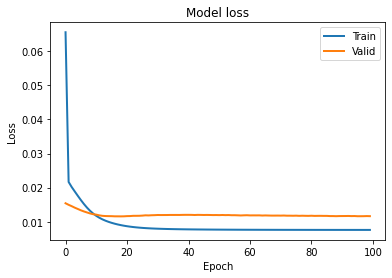

In [ ]:
plt.plot(autoencoder_history.history['loss'], linewidth=2, label='Train')
plt.plot(autoencoder_history.history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
""" validation predictions for threshold selection """
x_valid_pred = autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(X_valid_scaled - x_valid_pred, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_valid})

print('Validation reconstrunction error\n', sklearn.metrics.mean_squared_error(X_valid_scaled, x_valid_pred))

Validation reconstrunction error
 0.011695501584733814


In [ ]:
""" testing reconstruction error """
x_test_pred = autoencoder.predict(X_test_scaled)
print('Test reconstrunction error\n', sklearn.metrics.mean_squared_error(X_test_scaled, x_test_pred))

Test reconstrunction error
 0.015786956850160006


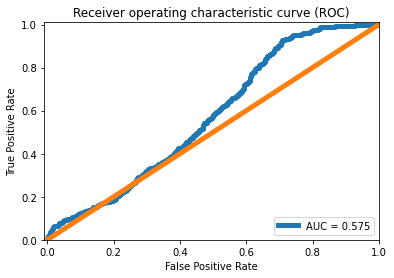

In [ ]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
""" Plot reconstruction errors for positive and negative data points """
mse = np.mean(np.power(X_test_scaled - x_test_pred, 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test})
threshold = round(np.mean(error_df.Reconstruction_error),2)
print(f"Threshold selected is: {threshold}")

Threshold selected is: 0.02


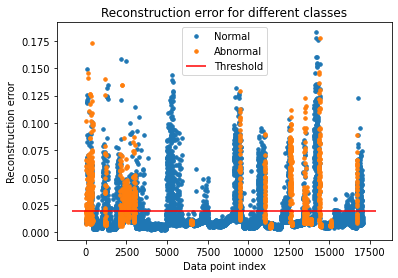

In [ ]:
""" Reconstruction error for different classes """
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Abnormal" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

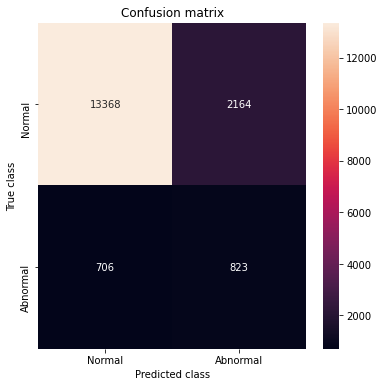

In [ ]:
""" Plot ROC Curve """

LABELS = ["Normal","Abnormal"]

pred_y = [1 if e > threshold else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

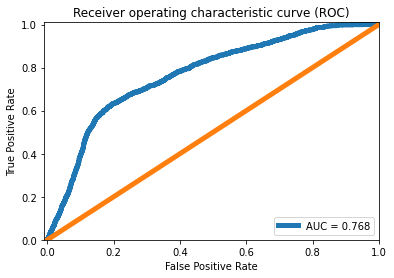

In [ ]:
""" plot the ROC curve again """
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Optimizing Autoencoder (no hyperparameter optimization)

> **1)** Equal weights -- encoder & decoder 

> **2)** Weight orthogonality -- encoder 

> **3)** Weight orthogonality -- encoder & decoder 

> **4)** Unit Norm Constraint -- encoder & decoder 

> **4)** Try Different Combinations & choose best 

> **4)** Plot Best Results 

> -- **Hyperparameter Optimization** -- 

In [ ]:
;""" weights are different between encoder and decoder """
w_encoder = np.round(np.transpose(autoencoder.layers[0].get_weights()[0]), 3)
w_decoder = np.round(autoencoder.layers[1].get_weights()[0], 3)
print('Encoder weights\n', w_encoder)
print('Decoder weights\n', w_decoder)

Encoder weights
 [[ 0.34   0.038  0.019  0.041 -0.229  0.292  0.392  0.01   0.097  0.051
  -0.343 -0.113 -0.193 -0.023  0.204 -0.276  0.202  0.334  0.023 -0.179
   0.017  0.177 -0.158 -0.158  0.155 -0.003  0.069 -0.26  -0.202  0.103
   0.109 -0.298 -0.148 -0.02   0.033 -0.066 -0.209 -0.04   0.102 -0.15
   0.227  0.006  0.13   0.081 -0.11   0.01  -0.043 -0.031 -0.286 -0.035
   0.103  0.284 -0.124  0.075  0.276 -0.246  0.266  0.069  0.026 -0.219
   0.196  0.184 -0.2   -0.052]
 [-0.018  0.192 -0.329 -0.287  0.144 -0.23   0.044  0.117  0.128  0.044
  -0.269 -0.099  0.36   0.087 -0.096 -0.212  0.072 -0.22  -0.083 -0.011
   0.211  0.232 -0.291  0.179 -0.079 -0.117  0.08  -0.265  0.23   0.017
   0.07  -0.373 -0.275 -0.045 -0.193 -0.135 -0.175 -0.284 -0.163  0.127
  -0.001  0.24  -0.085  0.122 -0.043 -0.033  0.014 -0.059  0.133  0.16
  -0.075  0.156 -0.159  0.22  -0.026  0.158 -0.288  0.193 -0.03   0.072
   0.138  0.117 -0.098 -0.072]]
Decoder weights
 [[ 0.547  0.164 -0.028 -0.231 -0.006 -0.0

In [ ]:
""" Ranjan, C. (2019, December 22). 
    Build the right Autoencoder - Tune and Optimize using PCA principles. Part II. 
    Retrieved November 09, 2020. 
"""
class DenseTied(Layer):
    def __init__(self, units,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 tied_to=None,
                 **kwargs):
        self.tied_to = tied_to
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super().__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True
                
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        if self.tied_to is not None:
            self.kernel = K.transpose(self.tied_to.kernel)
            self._non_trainable_weights.append(self.kernel)
        else:
            self.kernel = self.add_weight(shape=(input_dim, self.units),
                                          initializer=self.kernel_initializer,
                                          name='kernel',
                                          regularizer=self.kernel_regularizer,
                                          constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def call(self, inputs):
        output = K.dot(inputs, self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output

In [ ]:
encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias = True) 
decoder = DenseTied(input_dim, activation="linear", tied_to=encoder, use_bias = True)
autoencoder = Sequential()

autoencoder.add(encoder)
autoencoder.add(decoder)
autoencoder.compile(loss='mean_squared_error', optimizer='sgd')
autoencoder.summary()

autoencoder_history = autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled,
                epochs=epochs,
                batch_size=batch_size,
                validation_data = (X_valid_y0_scaled, X_valid_y0_scaled),
                shuffle=True,
                verbose=0)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 2)                 130       
_________________________________________________________________
dense_tied_6 (DenseTied)     (None, 64)                322       
Total params: 322
Trainable params: 194
Non-trainable params: 128
_________________________________________________________________


In [ ]:
""" weights are supposed to be equal """
w_encoder = np.round(np.transpose(autoencoder.layers[0].get_weights()[0]), 3)
w_decoder = np.round(autoencoder.layers[1].get_weights()[1], 3)
print('Encoder weights\n', w_encoder)
print('Decoder weights\n', w_decoder)

Encoder weights
 [[-0.105 -0.069  0.106 -0.242  0.132 -0.11   0.203  0.226 -0.105 -0.265
  -0.257 -0.251  0.014 -0.222 -0.07   0.28  -0.082  0.23  -0.195 -0.055
   0.111 -0.26   0.004 -0.172  0.031  0.182 -0.214  0.324 -0.115 -0.094
   0.055 -0.096 -0.177  0.137  0.069 -0.101  0.089 -0.011 -0.09   0.026
  -0.151  0.221  0.321 -0.237 -0.066  0.037  0.243  0.015 -0.223  0.244
   0.137 -0.016 -0.206  0.094  0.196 -0.267  0.25  -0.274 -0.077  0.016
   0.191  0.174  0.077 -0.082]
 [ 0.138 -0.226  0.146  0.18   0.076  0.218  0.183 -0.044 -0.223 -0.064
   0.021 -0.21  -0.241 -0.141 -0.01   0.071  0.16   0.056 -0.054  0.182
   0.236 -0.26   0.034  0.162  0.142 -0.271  0.058  0.04   0.259  0.204
  -0.123 -0.196 -0.276 -0.212  0.133  0.123  0.094 -0.167  0.142 -0.204
   0.035  0.228  0.223 -0.114  0.072  0.177  0.118 -0.246 -0.099 -0.13
   0.289 -0.152  0.017  0.108  0.189 -0.157 -0.039  0.272 -0.299  0.038
   0.008 -0.223 -0.005 -0.151]]
Decoder weights
 [[-0.105  0.138]
 [-0.069 -0.226]
 [ 0.1

In [ ]:
b_encoder = np.round(np.transpose(autoencoder.layers[0].get_weights()[1]), 3)
b_decoder = np.round(np.transpose(autoencoder.layers[1].get_weights()[0]), 3)
print('Encoder bias\n', b_encoder)
print('Decoder bias\n', b_decoder)

Encoder bias
 [-0.015 -0.   ]
Decoder bias
 [ 0.361  0.563  0.46   0.387  0.518  0.408  0.833  0.379  0.306  0.4
  0.422  0.505  0.229  0.293  0.387  0.56   0.421  0.527  0.473  0.476
  0.457  0.538  0.319  0.152  0.222  0.582  0.43   0.572  0.013  0.2
  0.472  0.598  0.57   0.618  0.44   0.406  0.501  0.567  0.811  0.457
  0.196  0.417  0.48   0.458  0.111  0.245  0.402  0.573 -0.018  0.11
 -0.034  0.131 -0.058 -0.014 -0.009  0.01   0.115 -0.136  0.121  0.026
  0.056  0.151  0.103  0.114]


In [ ]:
""" validation predictions for threshold selection """
x_valid_pred = autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(X_valid_scaled - x_valid_pred, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_valid})

print('Validation reconstrunction error\n', sklearn.metrics.mean_squared_error(X_valid_scaled, x_valid_pred))

Validation reconstrunction error
 0.016321615283485483


In [ ]:
""" testing reconstruction error """
x_test_pred = autoencoder.predict(X_test_scaled)
print('Test reconstrunction error\n', sklearn.metrics.mean_squared_error(X_test_scaled, x_test_pred))

Test reconstrunction error
 0.01994057595899215


In [ ]:
""" weight orthogonality """

""" Ranjan, C. (2019, December 22). 
    Build the right Autoencoder - Tune and Optimize using PCA principles. Part II. 
    Retrieved November 09, 2020. 
"""
class WeightsOrthogonalityConstraint (Constraint):
    def __init__(self, encoding_dim, weightage = 1.0, axis = 0):
        self.encoding_dim = encoding_dim
        self.weightage = weightage
        self.axis = axis
        
    def weights_orthogonality(self, w):
        if(self.axis==1):
            w = K.transpose(w)
        if(self.encoding_dim > 1):
            m = K.dot(K.transpose(w), w) - K.eye(self.encoding_dim)
            return self.weightage * K.sqrt(K.sum(K.square(m)))
        else:
            m = K.sum(w ** 2) - 1.
            return m

    def __call__(self, w):
        return self.weights_orthogonality(w)

In [ ]:
tf.__version__ # 2.3.0
tf.config.run_functions_eagerly(True) # for value error 

In [ ]:
""" encoder weight orthogonality """
encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias=True, 
                kernel_regularizer = WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0)) 
decoder = Dense(input_dim, activation="linear", use_bias = True)

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.compile(loss='mean_squared_error', optimizer='sgd')
autoencoder.summary()

start_time = time.time() 
autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled,
                epochs=epochs,
                batch_size=batch_size,
                validation_data = (X_valid_y0_scaled, X_valid_y0_scaled),
                shuffle=True,
                verbose=1)
end_time = time.time()
print(f"Training & Validation Time (seconds): {end_time - start_time}")

In [ ]:
""" close to orthogonal """
w_encoder = autoencoder.layers[0].get_weights()[0]
print('Encoder weights dot product\n', np.round(np.dot(w_encoder.T, w_encoder), 2))

w_decoder = autoencoder.layers[1].get_weights()[0]
print('Decoder weights dot product\n', np.round(np.dot(w_decoder, w_decoder.T), 2))

Encoder weights dot product
 [[ 0.97 -0.  ]
 [-0.    0.97]]
Decoder weights dot product
 [[2.34 0.06]
 [0.06 2.13]]


In [ ]:
""" validation predictions for threshold selection """
x_valid_pred = autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(X_valid_scaled - x_valid_pred, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_valid})

print('Validation reconstrunction error\n', sklearn.metrics.mean_squared_error(X_valid_scaled, x_valid_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Validation reconstrunction error
 0.011302129026290776


In [ ]:
""" testing reconstruction error """
x_test_pred = autoencoder.predict(X_test_scaled)
print('Test reconstrunction error\n', sklearn.metrics.mean_squared_error(X_test_scaled, x_test_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Test reconstrunction error
 0.015356530556431592


In [ ]:
""" encoder & decoder weight orthogonality """
encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias=True, 
                kernel_regularizer = WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0)) 
decoder = Dense(input_dim, activation="linear", use_bias = True, 
                kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=1))

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.compile(loss='mean_squared_error', optimizer='sgd')
autoencoder.summary()

start_time = time.time() 
autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled,
                epochs=epochs,
                batch_size=batch_size,
                validation_data = (X_valid_y0_scaled, X_valid_y0_scaled),
                shuffle=True,
                verbose=1)
end_time = time.time()
print(f"Training & Validation Time (seconds): {end_time - start_time}")

In [ ]:
""" vectors are orthogonal """
w_encoder = autoencoder.layers[0].get_weights()[0]
print('Encoder weights dot product\n', np.round(np.dot(w_encoder.T, w_encoder), 2))

w_decoder = autoencoder.layers[1].get_weights()[0]
print('Decoder weights dot product\n', np.round(np.dot(w_decoder, w_decoder.T), 2))

Encoder weights dot product
 [[ 1.01 -0.  ]
 [-0.    0.99]]
Decoder weights dot product
 [[ 1.01 -0.  ]
 [-0.    0.99]]


In [ ]:
""" For uncorrelated features, 
    penalty on the sum of off-diagonal elements of 
    the encoded features covariance
"""

""" Ranjan, C. (2019, December 22). 
    Build the right Autoencoder - Tune and Optimize using PCA principles. Part II. 
    Retrieved November 09, 2020. 
"""
class UncorrelatedFeaturesConstraint (Constraint):

    def __init__(self, encoding_dim, weightage=1.0):
        self.encoding_dim = encoding_dim
        self.weightage = weightage

    def get_covariance(self, x):
        x_centered_list = []

        for i in range(self.encoding_dim):
            x_centered_list.append(x[:, i] - K.mean(x[:, i]))

        x_centered = tf.stack(x_centered_list)
        covariance = K.dot(x_centered, K.transpose(x_centered)) / \
            tf.cast(x_centered.get_shape()[0], tf.float32)

        return covariance

    # Constraint penalty
    def uncorrelated_feature(self, x):
        if(self.encoding_dim <= 1):
            return 0.0
        else:
            output = K.sum(K.square(
                self.covariance - tf.math.multiply(self.covariance, tf.eye(self.encoding_dim))))
            return output

    def __call__(self, x):
        self.covariance = self.get_covariance(x)
        return self.weightage * self.uncorrelated_feature(x)

In [ ]:
""" apply the constraint on the model separately for encoder layer """
encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias=True, 
                activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.)) 
decoder = Dense(input_dim, activation="linear", use_bias = True)

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.compile(loss='mean_squared_error', optimizer='sgd')
autoencoder.summary()

start_time = time.time() 
autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled,
                epochs=epochs,
                batch_size=batch_size,
                validation_data = (X_valid_y0_scaled, X_valid_y0_scaled),
                shuffle=True,
                verbose=1)
end_time = time.time()
print(f"Training & Validation Time (seconds): {end_time - start_time}")

In [ ]:
""" validation predictions for threshold selection """
x_valid_pred = autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(X_valid_scaled - x_valid_pred, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_valid})

print('Validation reconstrunction error\n', sklearn.metrics.mean_squared_error(X_valid_scaled, x_valid_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Validation reconstrunction error
 0.012418306269190646


In [ ]:
""" testing reconstruction error """
x_test_pred = autoencoder.predict(X_test_scaled)
print('Test reconstrunction error\n', sklearn.metrics.mean_squared_error(X_test_scaled, x_test_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Test reconstrunction error
 0.01701600626067905


In [ ]:
""" For unit norm constraint, built-in Keras """

""" Ranjan, C. (2019, December 22). 
    Build the right Autoencoder - Tune and Optimize using PCA principles. Part II. 
    Retrieved November 09, 2020. 
"""
encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias = True, kernel_constraint=UnitNorm(axis=0)) 
decoder = Dense(input_dim, activation="linear", use_bias = True, kernel_constraint=UnitNorm(axis=1))
autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)
autoencoder.compile(loss='mean_squared_error', optimizer='sgd')
autoencoder.summary()

start_time = time.time() 
autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled,
                epochs=epochs,
                batch_size=batch_size,
                validation_data = (X_valid_y0_scaled, X_valid_y0_scaled),
                shuffle=True,
                verbose=1)
end_time = time.time()
print(f"Training & Validation Time (seconds): {end_time - start_time}")

In [ ]:
""" enforce unit norm constraint 
    Weights are not exactly 0 because it's not 
    a hard constraint 
"""
w_encoder = np.round(autoencoder.layers[0].get_weights()[0], 2).T 
w_decoder = np.round(autoencoder.layers[1].get_weights()[0], 2)  
print('Encoder weights norm, \n', np.round(np.sum(w_encoder ** 2, axis = 1),3))
print('Decoder weights norm, \n', np.round(np.sum(w_decoder ** 2, axis = 1),3))

Encoder weights norm, 
 [0.993 1.003]
Decoder weights norm, 
 [1.011 0.997]


## Variations 

In [ ]:
""" unit norm (encoder) & orthogonality """
encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias = True, 
                kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0), 
                kernel_constraint=UnitNorm(axis=0)) 
decoder = DenseTied(input_dim, activation="linear", tied_to=encoder, use_bias = False)

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.compile(loss='mean_squared_error', optimizer='sgd')
autoencoder.summary()

autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled,
                epochs=epochs,
                batch_size=batch_size,
                validation_data = (X_valid_y0_scaled, X_valid_y0_scaled),
                shuffle=True,
                verbose=1)

In [ ]:
""" validation predictions for threshold selection """
x_valid_pred = autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(X_valid_scaled - x_valid_pred, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_valid})

print('Validation reconstrunction error\n', sklearn.metrics.mean_squared_error(X_valid_scaled, x_valid_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Validation reconstrunction error
 0.15397720273036436


In [ ]:
""" testing reconstruction error """
x_test_pred = autoencoder.predict(X_test_scaled)
print('Test reconstrunction error\n', sklearn.metrics.mean_squared_error(X_test_scaled, x_test_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Test reconstrunction error
 0.14686625032582246


In [ ]:
""" unit norm (encoder, decoder) & orthogonality & uncorrelated features """
encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias = True, 
                kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0), 
                kernel_constraint=UnitNorm(axis=0),
                activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.)) 
decoder = DenseTied(input_dim, activation="linear", tied_to=encoder, use_bias = False, kernel_constraint=UnitNorm(axis=1))

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.compile(loss='mean_squared_error', optimizer='sgd')
autoencoder.summary()

start_time = time.time() 
autoencoder_history = autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled,
                epochs=epochs,
                batch_size=batch_size,
                validation_data = (X_valid_y0_scaled, X_valid_y0_scaled),
                shuffle=True,
                verbose=0)
end_time = time.time()
print(f"Training & Validation Time (seconds): {end_time - start_time}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 130       
_________________________________________________________________
dense_tied (DenseTied)       (None, 64)                258       
Total params: 258
Trainable params: 130
Non-trainable params: 128
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Training & Validation Time (seconds): 3436.9204223155975


In [ ]:
""" validation predictions for threshold selection """
x_valid_pred = autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(X_valid_scaled - x_valid_pred, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_valid})

print('Validation reconstrunction error\n', sklearn.metrics.mean_squared_error(X_valid_scaled, x_valid_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Validation reconstrunction error
 0.15402234884432664


In [ ]:
""" testing reconstruction error """
x_test_pred = autoencoder.predict(X_test_scaled)
print('Test reconstrunction error\n', sklearn.metrics.mean_squared_error(X_test_scaled, x_test_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Test reconstrunction error
 0.14659485453141297


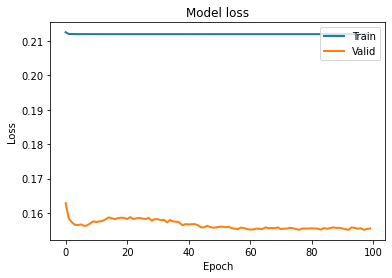

In [ ]:
""" not a good combination, try another """
plt.plot(autoencoder_history.history['loss'], linewidth=2, label='Train')
plt.plot(autoencoder_history.history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
""" orthogonality on encoding layer """
encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias = True, 
                kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0)
                ) 
decoder = DenseTied(input_dim, activation="linear", tied_to=encoder, use_bias = False)

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.compile(loss='mean_squared_error', optimizer='sgd')
autoencoder.summary()

start_time = time.time() 
autoencoder_history = autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled,
                epochs=epochs,
                batch_size=batch_size,
                validation_data = (X_valid_y0_scaled, X_valid_y0_scaled),
                shuffle=True,
                verbose=0)
end_time = time.time()
print(f"Training & Validation Time (seconds): {end_time - start_time}")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 130       
_________________________________________________________________
dense_tied_1 (DenseTied)     (None, 64)                258       
Total params: 258
Trainable params: 130
Non-trainable params: 128
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Training & Validation Time (seconds): 2172.599510908127


In [ ]:
""" validation predictions for threshold selection """
x_valid_pred = autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(X_valid_scaled - x_valid_pred, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_valid})

print('Validation reconstrunction error\n', sklearn.metrics.mean_squared_error(X_valid_scaled, x_valid_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Validation reconstrunction error
 0.15037281631526528


In [ ]:
""" testing reconstruction error """
x_test_pred = autoencoder.predict(X_test_scaled)
print('Test reconstrunction error\n', sklearn.metrics.mean_squared_error(X_test_scaled, x_test_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Test reconstrunction error
 0.1429053777386471


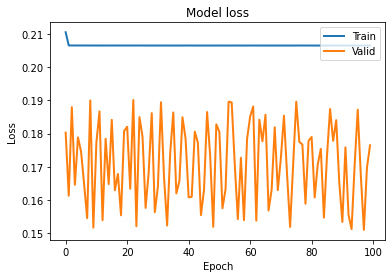

In [ ]:
""" not a good combination, try another """
plt.plot(autoencoder_history.history['loss'], linewidth=2, label='Train')
plt.plot(autoencoder_history.history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
""" uncorrelated features & orthogonality """
encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias = True, 
                kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0),
                activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.)
                ) 
decoder = DenseTied(input_dim, activation="linear", tied_to=encoder, use_bias = False)

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.compile(loss='mean_squared_error', optimizer='sgd')
autoencoder.summary()

start_time = time.time() 
autoencoder_history = autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled,
                epochs=epochs,
                batch_size=batch_size,
                validation_data = (X_valid_y0_scaled, X_valid_y0_scaled),
                shuffle=True,
                verbose=0)
end_time = time.time()
print(f"Training & Validation Time (seconds): {end_time - start_time}")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 2)                 130       
_________________________________________________________________
dense_tied_2 (DenseTied)     (None, 64)                258       
Total params: 258
Trainable params: 130
Non-trainable params: 128
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Training & Validation Time (seconds): 3385.332553625107


In [ ]:
""" validation predictions for threshold selection """
x_valid_pred = autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(X_valid_scaled - x_valid_pred, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_valid})

print('Validation reconstrunction error\n', sklearn.metrics.mean_squared_error(X_valid_scaled, x_valid_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Validation reconstrunction error
 0.1544054061662229


In [ ]:
""" testing reconstruction error """
x_test_pred = autoencoder.predict(X_test_scaled)
print('Test reconstrunction error\n', sklearn.metrics.mean_squared_error(X_test_scaled, x_test_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Test reconstrunction error
 0.1470316963147079


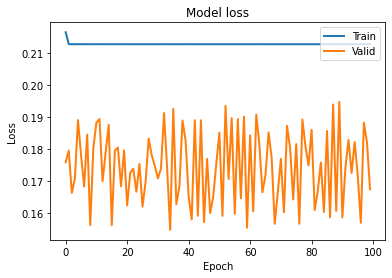

In [ ]:
""" not a good combination, try another """
plt.plot(autoencoder_history.history['loss'], linewidth=2, label='Train')
plt.plot(autoencoder_history.history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
""" instead of Dense Tied, try Dense """
""" unit norm (encoder) & orthogonality """
encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias = True, 
                kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0), 
                kernel_constraint=UnitNorm(axis=0)) 
decoder = Dense(input_dim, activation="linear", use_bias = False)

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.compile(loss='mean_squared_error', optimizer='sgd')
autoencoder.summary()

autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled,
                epochs=epochs,
                batch_size=batch_size,
                validation_data = (X_valid_y0_scaled, X_valid_y0_scaled),
                shuffle=True,
                verbose=0)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 2)                 130       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                128       
Total params: 258
Trainable params: 258
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [ ]:
""" validation predictions for threshold selection """
x_valid_pred = autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(X_valid_scaled - x_valid_pred, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_valid})

print('Validation reconstrunction error\n', sklearn.metrics.mean_squared_error(X_valid_scaled, x_valid_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Validation reconstrunction error
 0.013186410647921667


In [ ]:
""" testing reconstruction error """
x_test_pred = autoencoder.predict(X_test_scaled)
print('Test reconstrunction error\n', sklearn.metrics.mean_squared_error(X_test_scaled, x_test_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Test reconstrunction error
 0.016639725467999345


In [ ]:
""" unit norm & orthogonality with Dense decoder """
epochs = 50 # loss remains same afterwards 

encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias = True, 
                kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0), 
                kernel_constraint=UnitNorm(axis=0)) 
decoder = Dense(input_dim, activation="linear", use_bias = True)

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.compile(loss='mean_squared_error', optimizer='sgd')
autoencoder.summary()

autoencoder_history = autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled,
                epochs=epochs,
                batch_size=batch_size,
                validation_data = (X_valid_y0_scaled, X_valid_y0_scaled),
                shuffle=True,
                verbose=0)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 2)                 130       
_________________________________________________________________
dense_23 (Dense)             (None, 64)                192       
Total params: 322
Trainable params: 322
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [ ]:
""" validation predictions for threshold selection """
x_valid_pred = autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(X_valid_scaled - x_valid_pred, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_valid})

print('Validation reconstrunction error\n', sklearn.metrics.mean_squared_error(X_valid_scaled, x_valid_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Validation reconstrunction error
 0.012138255026548793


In [ ]:
""" testing reconstruction error """
x_test_pred = autoencoder.predict(X_test_scaled)
print('Test reconstrunction error\n', sklearn.metrics.mean_squared_error(X_test_scaled, x_test_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Test reconstrunction error
 0.016858295888910083


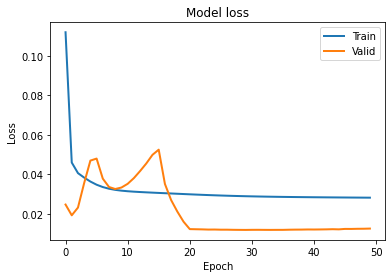

In [ ]:
plt.plot(autoencoder_history.history['loss'], linewidth=2, label='Train')
plt.plot(autoencoder_history.history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
""" Plot reconstruction errors for positive and negative data points """
mse = np.mean(np.power(X_test_scaled - x_test_pred, 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test})
threshold = round(np.mean(error_df.Reconstruction_error),2)
print(f"Threshold selected is: {threshold}")

Threshold selected is: 0.02


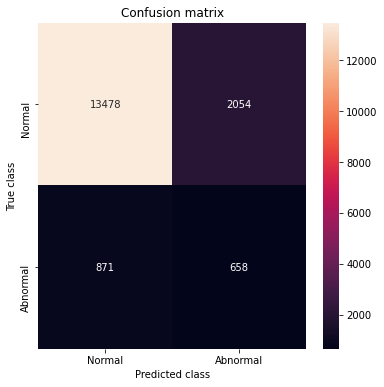

In [ ]:
""" Plot ROC Curve """

LABELS = ["Normal","Abnormal"]

pred_y = [1 if e > threshold else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

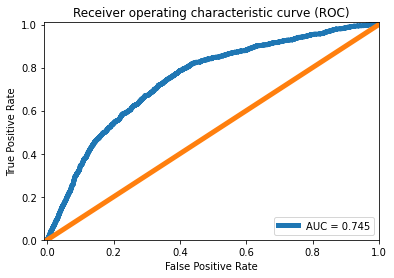

In [ ]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
""" uncorrelated features & orthogonality """
encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias = True, 
                kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0),
                activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.)
                ) 
decoder = Dense(input_dim, activation="linear", use_bias = True)

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.compile(loss='mean_squared_error', optimizer='sgd')
autoencoder.summary()

start_time = time.time() 
autoencoder_history = autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled,
                epochs=epochs,
                batch_size=batch_size,
                validation_data = (X_valid_y0_scaled, X_valid_y0_scaled),
                shuffle=True,
                verbose=0)
end_time = time.time()
print(f"Training & Validation Time (seconds): {end_time - start_time}")

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 2)                 130       
_________________________________________________________________
dense_15 (Dense)             (None, 64)                192       
Total params: 322
Trainable params: 322
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Training & Validation Time (seconds): 1758.8751661777496


In [ ]:
""" validation predictions for threshold selection """
x_valid_pred = autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(X_valid_scaled - x_valid_pred, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_valid})

print('Validation reconstrunction error\n', sklearn.metrics.mean_squared_error(X_valid_scaled, x_valid_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Validation reconstrunction error
 0.012889027885537276


In [ ]:
""" testing reconstruction error """
x_test_pred = autoencoder.predict(X_test_scaled)
print('Test reconstrunction error\n', sklearn.metrics.mean_squared_error(X_test_scaled, x_test_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Test reconstrunction error
 0.0174387842871356


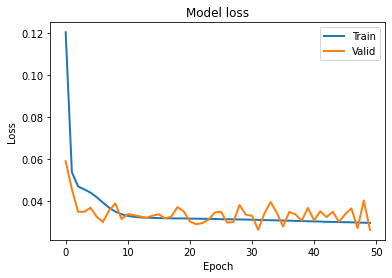

In [ ]:
plt.plot(autoencoder_history.history['loss'], linewidth=2, label='Train')
plt.plot(autoencoder_history.history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
""" uncorrelated features & unit norm """
encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias = True, 
                kernel_constraint=UnitNorm(axis=0),
                activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.)
                ) 
decoder = Dense(input_dim, activation="linear", use_bias = True)

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.compile(loss='mean_squared_error', optimizer='sgd')
autoencoder.summary()

start_time = time.time() 
autoencoder_history = autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled,
                epochs=epochs,
                batch_size=batch_size,
                validation_data = (X_valid_y0_scaled, X_valid_y0_scaled),
                shuffle=True,
                verbose=0)
end_time = time.time()
print(f"Training & Validation Time (seconds): {end_time - start_time}")

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 2)                 130       
_________________________________________________________________
dense_17 (Dense)             (None, 64)                192       
Total params: 322
Trainable params: 322
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Training & Validation Time (seconds): 1533.9186525344849


In [ ]:
""" validation predictions for threshold selection """
x_valid_pred = autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(X_valid_scaled - x_valid_pred, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_valid})

print('Validation reconstrunction error\n', sklearn.metrics.mean_squared_error(X_valid_scaled, x_valid_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Validation reconstrunction error
 0.01308769150862013


In [ ]:
""" testing reconstruction error """
x_test_pred = autoencoder.predict(X_test_scaled)
print('Test reconstrunction error\n', sklearn.metrics.mean_squared_error(X_test_scaled, x_test_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Test reconstrunction error
 0.0175622112034411


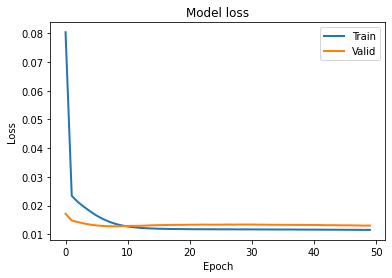

In [ ]:
plt.plot(autoencoder_history.history['loss'], linewidth=2, label='Train')
plt.plot(autoencoder_history.history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

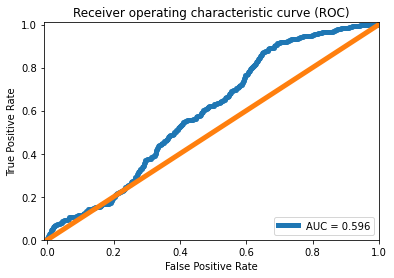

In [ ]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
""" Plot reconstruction errors for positive and negative data points """
mse = np.mean(np.power(X_test_scaled - x_test_pred, 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test})
threshold = round(np.mean(error_df.Reconstruction_error),2)
print(f"Threshold selected is: {threshold}")

Threshold selected is: 0.02


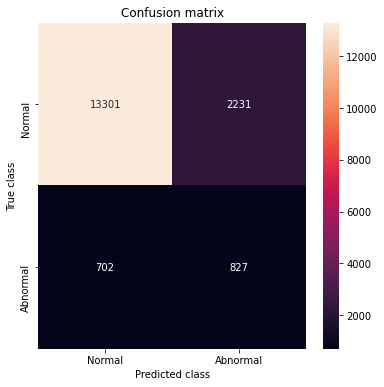

In [ ]:
""" Plot ROC Curve """

LABELS = ["Normal","Abnormal"]

pred_y = [1 if e > threshold else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

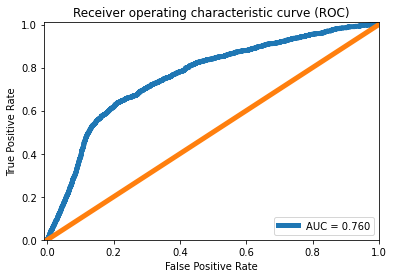

In [ ]:
""" plot the ROC curve again """
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
""" unit norm & orthogonality, no bias for decoder """
encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias = True, 
                kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0), 
                kernel_constraint=UnitNorm(axis=0),
                # activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.)
                ) 
decoder = Dense(input_dim, activation="linear", use_bias = False)

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.compile(loss='mean_squared_error', optimizer='sgd')
autoencoder.summary()

start_time = time.time() 
autoencoder_history = autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled,
                epochs=epochs,
                batch_size=batch_size,
                validation_data = (X_valid_y0_scaled, X_valid_y0_scaled),
                shuffle=True,
                verbose=0)
end_time = time.time()
print(f"Training & Validation Time (seconds): {end_time - start_time}")

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 2)                 130       
_________________________________________________________________
dense_27 (Dense)             (None, 64)                128       
Total params: 258
Trainable params: 258
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Training & Validation Time (seconds): 1186.683257818222


In [ ]:
""" validation predictions for threshold selection """
x_valid_pred = autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(X_valid_scaled - x_valid_pred, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_valid})

print('Validation reconstrunction error\n', sklearn.metrics.mean_squared_error(X_valid_scaled, x_valid_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Validation reconstrunction error
 0.013194101807046815


In [ ]:
""" testing reconstruction error """
x_test_pred = autoencoder.predict(X_test_scaled)
print('Test reconstrunction error\n', sklearn.metrics.mean_squared_error(X_test_scaled, x_test_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Test reconstrunction error
 0.01666679470894422


In [ ]:
""" Plot reconstruction errors for positive and negative data points """
mse = np.mean(np.power(X_test_scaled - x_test_pred, 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test})
threshold = round(np.mean(error_df.Reconstruction_error),2)
print(f"Threshold selected is: {threshold}")

Threshold selected is: 0.02


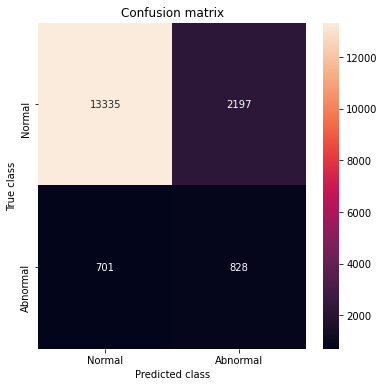

In [ ]:
""" Plot ROC Curve """

LABELS = ["Normal","Abnormal"]

pred_y = [1 if e > threshold else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

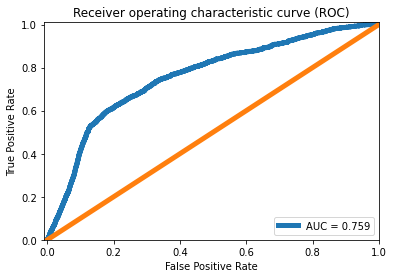

In [ ]:
""" plot the ROC curve again """
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
""" run if necessary for packages used in the program """
!pip freeze > requirements.txt 